# 移動平均線\_2曲線での利益最大化回帰

## アイデア
短期曲線が長期曲線を超える瞬間は**ゴールデンクロス**と呼ばれ、この瞬間に買うのが良いとされている。  
しかし、この短期曲線や長期曲線のパラメータ（何分前の平均か、近似度など）は最適化されていない。  
これを、利益が最大化するように回帰で求める。  

## +α
「短期曲線が長期曲線を超えたら買い」という単純なものでは、可視化した際に見づらかったり、
ブレが生じやすいことになってしまう懸念がある。


- 超える際の傾きの差
- 超える数分前に何回クロスしているか

などの売買条件をつけても良い。

In [6]:
from init import config

In [9]:
# データ取得
import db
SAMPLING_SEC_BY = None#60*100
ticker = db.df.read_ticker(start="2017-12-28")

2018-01-03 23:46:13,639 INFO sqlalchemy.engine.base.Engine DESCRIBE `SELECT * FROM ticker `
2018-01-03 23:46:13,641 INFO sqlalchemy.engine.base.Engine ()
2018-01-03 23:46:13,654 INFO sqlalchemy.engine.base.Engine ROLLBACK
2018-01-03 23:46:13,672 INFO sqlalchemy.engine.base.Engine SELECT * FROM ticker 
2018-01-03 23:46:13,673 INFO sqlalchemy.engine.base.Engine ()


In [11]:
sma

,ltp
timestamp,
2017-12-28 00:00:00+09:00,NaN
2017-12-28 00:01:00+09:00,NaN
2017-12-28 00:02:00+09:00,NaN
2017-12-28 00:03:00+09:00,NaN
2017-12-28 00:04:00+09:00,NaN
2017-12-28 00:05:00+09:00,NaN
2017-12-28 00:06:00+09:00,NaN
2017-12-28 00:07:00+09:00,1.754926e+06
2017-12-28 00:08:00+09:00,1.752849e+06


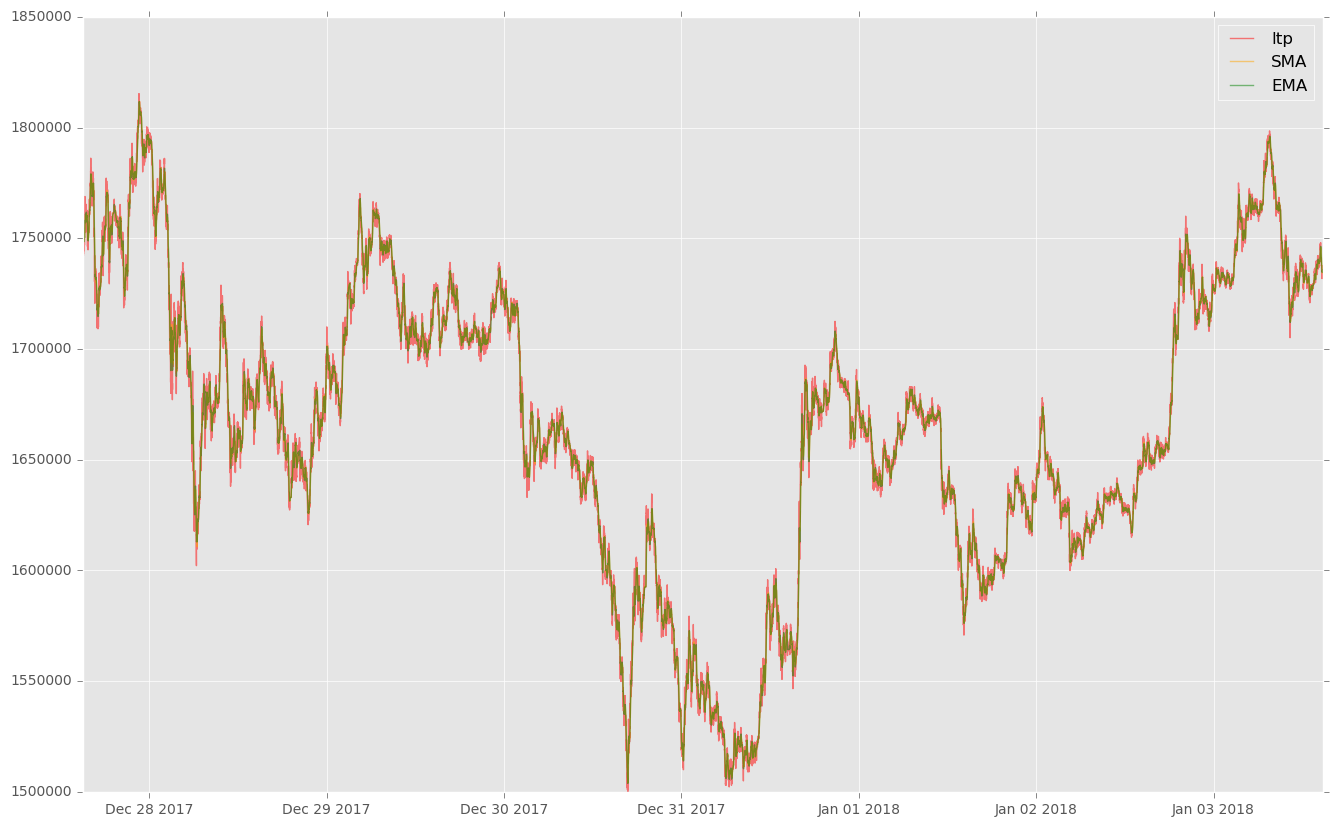

In [28]:
%matplotlib inline
import pandas as pd
from plotter.plot import plt, set_figure
set_figure((16,10))

#  元データ
ltp = ticker[["ltp"]]
plt.plot(ltp, label="ltp", alpha=0.5, color="r")

# 指定の単位でgroup by的にまとめておく。
ltp_min = ltp.groupby(pd.Grouper(freq='min')).mean()
# plt.plot(ltp_min, label="ltp_min", alpha=0.5, color="purple")

# SMA（単純移動平均 : Simple Moving Average）
sma = ltp_min.rolling(window=8).mean() # 分
plt.plot(sma, label="SMA", alpha=0.5, color="orange")

# EMA（指値平滑移動平均 : Exponentially Smoothed Moving Average）
# EWMA（指数加重移動平均  ： Exponentially Weighted Moving Average）
ema = ltp.ewm(span=30).mean()
plt.plot(ema, label="EMA", alpha=0.5, color="green")

_ = plt.legend()

In [25]:
ltp.index.dtype

datetime64[ns, Asia/Tokyo]

In [55]:
ltp.dtypes

ltp    object
dtype: object

In [56]:
ltp.astype(dtype=float).dtypes

ltp    float64
dtype: object

In [57]:
ltp_min = ltp.astype(dtype=float).groupby(pd.Grouper(freq='min')).mean()

In [58]:
ltp_min

,ltp
2018-01-03 20:41:00+09:00,1.738500e+06
2018-01-03 20:42:00+09:00,1.737944e+06
2018-01-03 20:43:00+09:00,1.740999e+06
2018-01-03 20:44:00+09:00,1.741429e+06
2018-01-03 20:45:00+09:00,1.741378e+06
2018-01-03 20:46:00+09:00,1.741980e+06
2018-01-03 20:47:00+09:00,1.739134e+06
2018-01-03 20:48:00+09:00,1.736662e+06
2018-01-03 20:49:00+09:00,1.737246e+06
2018-01-03 20:50:00+09:00,1.737276e+06
